In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!tar -xvf /content/drive/MyDrive/processedimagesfinal.tar.gz processedimages/

Streaming output truncated to the last 5000 lines.
processedimages/"131459315949_10153444036540950".jpg
processedimages/"86680728811_10154793937248812".jpg
processedimages/"228735667216_10153386423967217".jpg
processedimages/"228735667216_10153427615107217".jpg
processedimages/"131459315949_10153506954360950".jpg
processedimages/"228735667216_10153545641222217".jpg
processedimages/"228735667216_10153565100852217".jpg
processedimages/"5550296508_10155541189211509".jpg
processedimages/"228735667216_10153199010437217".jpg
processedimages/"131459315949_10153524138030950".jpg
processedimages/"228735667216_10153764684212217".jpg
processedimages/"86680728811_10154169958108812".jpg
processedimages/"86680728811_10154843593553812".jpg
processedimages/"131459315949_10153415476155950".jpg
processedimages/"15704546335_10154123178886336".jpg
processedimages/"10643211755_10154674469731756".jpg
processedimages/"155869377766434_955815271105170".jpg
processedimages/"131459315949_10153920203335950".jpg
p

In [ ]:
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from random import randrange
import torch.nn.functional as F
from sklearn.metrics import f1_score
import seaborn as sns
from torch.autograd import Variable
import cv2
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps=PorterStemmer()
nltk.download('stopwords')
stopwords=set(stopwords.words('english'))
plt.ion()   # interactive mode
%matplotlib inline
import tensorflow as tf
sns.set_style('darkgrid')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('/content/drive/My Drive/trainingDataMultimodalPredictorCompleteReactions.csv')
df

,index,Unnamed: 0,Unnamed: 0.1,id,page_id,name,status_message,description,caption,post_type,...,num_hahas,num_sads,num_thanks,num_angrys,link,picture,posted_at,picture_url,images,text
0,0,0,1453,"""86680728811_435182833161558""",86680728811,Adam Yauch of the Beastie Boys Dies After Canc...,Beastie Boys' Member Adam Yauch Dead at 47,"Adam Yauch, part of the groundbreaking hip-ho...",abcnews.go.com,link,...,0,1,0,0,http://abcnews.go.com/blogs/entertainment/2012...,https://external.xx.fbcdn.net/safe_image.php?d...,2012-05-04T18:05:50,http://a.abcnews.go.com/images/Entertainment/g...,"""86680728811_435182833161558"".jpg",Beastie Boys' Member Adam Yauch Dead at 47
1,1,1,1757,"""86680728811_471680039515399""",86680728811,Richard Dawson Dies: 'Family Feud' Host Was 79,Dawson had a small role in the “Dick Van Dyke ...,Richard Dawson known best for hosting the “Fam...,abcnews.go.com,link,...,0,1,0,0,http://abcnews.go.com/blogs/entertainment/2012...,https://external.xx.fbcdn.net/safe_image.php?d...,2012-06-03T16:28:39,http://abcnews.go.com/images/US/gty_richard_da...,"""86680728811_471680039515399"".jpg",Dawson had a small role in the “Dick Van Dyke ...
2,2,2,1996,"""86680728811_298377313592582""",86680728811,Millionaire's Disappearance Staged? Wife's Law...,Missing Florida millionaire Guma Aguiar could ...,Guma Aguiar's wife and mother battle over miss...,abcnews.go.com,link,...,0,0,0,0,http://abcnews.go.com/US/missing-millionaire-g...,https://external.xx.fbcdn.net/safe_image.php?d...,2012-06-30T10:50:01,http://a.abcnews.go.com/images/US/abc_guma_agu...,"""86680728811_298377313592582"".jpg",Missing Florida millionaire Guma Aguiar could ...
3,3,3,2213,"""86680728811_333477760066733""",86680728811,Sage Stallone Dead: No Signs of Foul Play,Authorities said there were no signs of forced...,His cause of death remains undetermined.,abcnews.go.com,link,...,0,1,0,0,http://abcnews.go.com/Entertainment/sage-stall...,https://external.xx.fbcdn.net/safe_image.php?d...,2012-07-14T15:20:01,http://a.abcnews.go.com/images/US/gty_sage_sta...,"""86680728811_333477760066733"".jpg",Authorities said there were no signs of forced...
4,4,4,3097,"""86680728811_530634013619238""",86680728811,"Blind Pet Dachshund Paints, Saves Fellow Rescu...",After DeeDee Murray's pet dachshund went blind...,"DeeDee Murray, who has made a career as a pain...",abcnews.go.com,link,...,0,0,0,0,http://abcnews.go.com/blogs/headlines/2012/09/...,https://external.xx.fbcdn.net/safe_image.php?d...,2012-09-09T16:00:01,http://abcnews.go.com/images/US/abc_dog_artist...,"""86680728811_530634013619238"".jpg",After DeeDee Murray's pet dachshund went blind...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65581,65581,65581,275566,"""5863113009_10154788850248010""",5863113009,President Obama to Bill Maher: 'If I watched F...,"300,000 people signed a petition urging Presid...",President Obama has participated in plenty of ...,latimes.com,link,...,1014,9,0,19,http://www.latimes.com/entertainment/movies/la...,https://external.xx.fbcdn.net/safe_image.php?d...,2016-11-06T22:40:00,http://www.trbimg.com/img-581e880a/turbine/la-...,"""5863113009_10154788850248010"".jpg","300,000 people signed a petition urging Presid..."
65582,65582,65582,275567,"""5863113009_10154788694053010""",5863113009,Did a fisherman fairly catch a prizewinning ma...,There's a catch.,Fishermen are known to tell tales.,latimes.com,link,...,1,0,0,2,http://www.latimes.com/nation/la-na-fishing-la...,https://external.xx.fbcdn.net/safe_image.php?d...,2016-11-06T23:15:00,http://www.trbimg.com/img-581e7d07/turbine/la-...,"""5863113009_10154788694053010"".jpg",There's a catch.
65583,65583,65583,275576,"""5863113009_10154789905248010""",5863113009,Ms. Marvel urges Americans to vote,She's urging voters to tap into their own supe...,Looks like everyone wants folks to get out and...,latimes.com,link,...,7,0,0,0,http://www.latimes.com/entertainment/herocompl...,https://external.xx.fbcdn.net/safe_image.p

In [ ]:
mul_df=df[['images', 'text','num_loves', 'num_wows',
       'num_hahas', 'num_sads','num_angrys']]

In [ ]:
reactions=mul_df[['num_loves', 'num_wows', 'num_hahas', 'num_sads', 'num_angrys']]
mul_df['labels']=reactions.values.argmax(1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
mul_df=mul_df.dropna().reset_index(drop=True)

In [ ]:
len(mul_df)

65300

In [ ]:
mul_df=mul_df.sample(n=20000)
mul_df=mul_df.reset_index(drop=True)
mul_df

,images,text,num_loves,num_wows,num_hahas,num_sads,num_angrys,labels
0,"""131459315949_10154039159120950"".jpg","Trump may look weak in the Electoral College, ...",81,6,25,11,99,4
1,"""5550296508_10154862595396509"".jpg",Hundreds of families are reportedly being used...,0,8,3,121,129,4
2,"""131459315949_10153548558365950"".jpg",Look familiar?,70,10,2,2,0,0
3,"""15704546335_10154325741586336"".jpg",The weapon is called a railgun and is powered ...,186,451,12,6,6,1
4,"""228735667216_10153758888937217"".jpg",Anyone looking for a new job?,239,19,114,4,5,0
...,...,...,...,...,...,...,...,...
19995,"""10643211755_10154417432581756"".jpg",Scientists long had been searching for such mi...,89,474,16,3,2,1
19996,"""228735667216_10153636807517217"".jpg",A man in the advert is 'washed' a different co...,24,157,440,72,873,4
19997,"""155869377766434_1493382164015142"".jpg",Take a look for yourself.,23,103,342,32,504,4
19998,"""5550296508_10154428776336509"".jpg",China's crucial factory sector is sputtering.,3,1,3,0,0,0


In [ ]:
import cv2
out=[]
for img in mul_df['images']:
      im=cv2.imread('/content/processedimages/'+img)
      if im is None:
          mul_df.drop(mul_df.index[mul_df['images'] == img], inplace=True)


In [ ]:
def cleaner(text):
    text=str(text)
    cleaned=text.replace("//"," ").replace("."," ")
    cleaned=re.sub(r'[^a-zA-Z]'," ",cleaned)
    cleaned=cleaned.strip() #removing whitespace
    cleaned=cleaned.lower() #converting into lower case words
    cleaned=re.sub(r'\w+\d+'," ",cleaned)#remove alphanumeric words
    cleaned=ps.stem(cleaned) #stemming 
    cleaned=[word for word in cleaned.split() if len(word)>2]
    cleaned=" ".join(cleaned)
    return cleaned
mul_df['text']=mul_df['text'].apply(lambda text:cleaner(text))

In [ ]:
mul_df.reset_index(inplace=True)

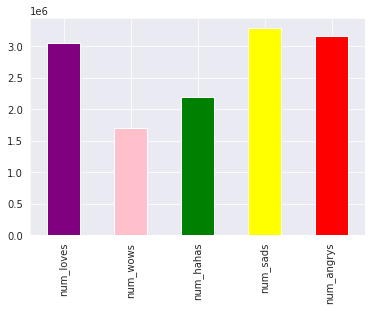

In [ ]:
def plot():
    stats = mul_df[['num_loves', 'num_wows', 'num_hahas', 'num_sads', 'num_angrys']].sum()
    stats.plot(kind='bar', color=['purple', 'pink', 'green', 'yellow', 'red'])
    plt.show()
plot()

In [ ]:
mul_df

,index,images,text,num_loves,num_wows,num_hahas,num_sads,num_angrys,labels
0,0,"""131459315949_10154039159120950"".jpg",trump may look weak the electoral college line...,81,6,25,11,99,4
1,1,"""5550296508_10154862595396509"".jpg",hundreds families are reportedly being used is...,0,8,3,121,129,4
2,2,"""131459315949_10153548558365950"".jpg",look familiar,70,10,2,2,0,0
3,3,"""15704546335_10154325741586336"".jpg",the weapon called railgun and powered electrom...,186,451,12,6,6,1
4,4,"""228735667216_10153758888937217"".jpg",anyone looking for new job,239,19,114,4,5,0
...,...,...,...,...,...,...,...,...,...
19964,19995,"""10643211755_10154417432581756"".jpg",scientists long had been searching for such mi...,89,474,16,3,2,1
19965,19996,"""228735667216_10153636807517217"".jpg",man the advert washed different colour,24,157,440,72,873,4
19966,19997,"""155869377766434_1493382164015142"".jpg",take look for yourself,23,103,342,32,504,4
19967,19998,"""5550296508_10154428776336509"".jpg",china crucial factory sector sputt,3,1,3,0,0,0


In [ ]:
type(mul_df)

pandas.core.frame.DataFrame

In [ ]:
final_df = mul_df[['images','labels']]
final_df

,images,labels
0,"""131459315949_10154039159120950"".jpg",4
1,"""5550296508_10154862595396509"".jpg",4
2,"""131459315949_10153548558365950"".jpg",0
3,"""15704546335_10154325741586336"".jpg",1
4,"""228735667216_10153758888937217"".jpg",0
...,...,...
19964,"""10643211755_10154417432581756"".jpg",1
19965,"""228735667216_10153636807517217"".jpg",4
19966,"""155869377766434_1493382164015142"".jpg",4
19967,"""5550296508_10154428776336509"".jpg",0


In [ ]:
final_df['images'].iloc[1]

'"5550296508_10154862595396509".jpg'

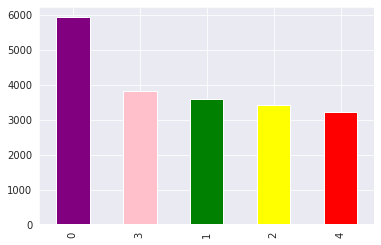

In [ ]:
stats = final_df['labels'].value_counts()
stats.plot(kind='bar', color=['purple', 'pink', 'green', 'yellow', 'red'])
plt.show()

In [ ]:
print(final_df['labels'].value_counts()[2])
print(final_df['labels'].value_counts()[1])
print(final_df['labels'].value_counts()[3])
print(final_df['labels'].value_counts()[4])
print(final_df['labels'].value_counts()[0])


3420
3584
3818
3216
5931


In [ ]:
FR=final_df[final_df['labels']!=0]


In [ ]:
FR=FR.reset_index(drop=True)
FR

,images,labels
0,"""131459315949_10154039159120950"".jpg",4
1,"""5550296508_10154862595396509"".jpg",4
2,"""15704546335_10154325741586336"".jpg",1
3,"""131459315949_10153495838400950"".jpg",1
4,"""155869377766434_1492459657440726"".jpg",4
...,...,...
14033,"""86680728811_10154944888278812"".jpg",4
14034,"""15704546335_10153763091191336"".jpg",2
14035,"""10643211755_10154417432581756"".jpg",1
14036,"""228735667216_10153636807517217"".jpg",4


In [ ]:
F0=final_df[final_df['labels']==0]

In [ ]:
F0=F0[:12600]
F0

,images,labels
2,"""131459315949_10153548558365950"".jpg",0
4,"""228735667216_10153758888937217"".jpg",0
5,"""155869377766434_1511506912202667"".jpg",0
9,"""228735667216_10153277066792217"".jpg",0
10,"""10643211755_10154823082721756"".jpg",0
...,...,...
19950,"""155869377766434_1309009215785772"".jpg",0
19953,"""10643211755_10154425594466756"".jpg",0
19962,"""5550296508_10154238819351509"".jpg",0
19967,"""5550296508_10154428776336509"".jpg",0


In [ ]:
F0=F0.reset_index(drop=True)
F0

,images,labels
0,"""131459315949_10153548558365950"".jpg",0
1,"""228735667216_10153758888937217"".jpg",0
2,"""155869377766434_1511506912202667"".jpg",0
3,"""228735667216_10153277066792217"".jpg",0
4,"""10643211755_10154823082721756"".jpg",0
...,...,...
5926,"""155869377766434_1309009215785772"".jpg",0
5927,"""10643211755_10154425594466756"".jpg",0
5928,"""5550296508_10154238819351509"".jpg",0
5929,"""5550296508_10154428776336509"".jpg",0


In [ ]:
final_df=pd.concat([FR,F0])

In [ ]:
final_df=final_df.reset_index(drop=True)
final_df

,images,labels
0,"""131459315949_10154039159120950"".jpg",4
1,"""5550296508_10154862595396509"".jpg",4
2,"""15704546335_10154325741586336"".jpg",1
3,"""131459315949_10153495838400950"".jpg",1
4,"""155869377766434_1492459657440726"".jpg",4
...,...,...
19964,"""155869377766434_1309009215785772"".jpg",0
19965,"""10643211755_10154425594466756"".jpg",0
19966,"""5550296508_10154238819351509"".jpg",0
19967,"""5550296508_10154428776336509"".jpg",0


In [ ]:
from PIL import Image 
import PIL 
  
path='/content/processedimages/'
PIL=[]
for i in final_df['images']:
         im = Image.open(path+i) 
         PIL.append(im)

In [ ]:
PIL

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7F142BC07A50>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7F142BB69290>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7F142BB69E90>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7F142BB6F550>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256 at 0x7F142BB6F650>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7F142BB6F7D0>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7F142BB6F890>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7F142BB6F990>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7F142BB6FA90>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7F142BB6F710>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7F142BB6FC50>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7F142BB6

In [ ]:
final_df['PIL']=PIL

In [ ]:
features=['num_loves','num_wows','num_hahas','num_sads','num_angrys']
fea=[]
for i in final_df['labels']:
       i=features[i]
       fea.append(i)
      

In [ ]:
fea

['num_angrys',
 'num_angrys',
 'num_wows',
 'num_wows',
 'num_angrys',
 'num_angrys',
 'num_sads',
 'num_angrys',
 'num_wows',
 'num_hahas',
 'num_wows',
 'num_hahas',
 'num_angrys',
 'num_wows',
 'num_hahas',
 'num_sads',
 'num_angrys',
 'num_angrys',
 'num_wows',
 'num_angrys',
 'num_hahas',
 'num_hahas',
 'num_wows',
 'num_angrys',
 'num_wows',
 'num_angrys',
 'num_wows',
 'num_sads',
 'num_angrys',
 'num_sads',
 'num_angrys',
 'num_hahas',
 'num_wows',
 'num_wows',
 'num_wows',
 'num_angrys',
 'num_wows',
 'num_wows',
 'num_angrys',
 'num_hahas',
 'num_hahas',
 'num_angrys',
 'num_wows',
 'num_hahas',
 'num_hahas',
 'num_sads',
 'num_sads',
 'num_hahas',
 'num_hahas',
 'num_wows',
 'num_angrys',
 'num_hahas',
 'num_hahas',
 'num_hahas',
 'num_hahas',
 'num_angrys',
 'num_wows',
 'num_sads',
 'num_hahas',
 'num_wows',
 'num_wows',
 'num_hahas',
 'num_sads',
 'num_angrys',
 'num_hahas',
 'num_hahas',
 'num_sads',
 'num_wows',
 'num_sads',
 'num_hahas',
 'num_angrys',
 'num_hahas',
 '

In [ ]:
final_df['label']=fea

In [ ]:
final_df

,images,labels,PIL,label
0,"""131459315949_10154039159120950"".jpg",4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,num_angrys
1,"""5550296508_10154862595396509"".jpg",4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,num_angrys
2,"""15704546335_10154325741586336"".jpg",1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,num_wows
3,"""131459315949_10153495838400950"".jpg",1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,num_wows
4,"""155869377766434_1492459657440726"".jpg",4,<PIL.PngImagePlugin.PngImageFile image mode=RG...,num_angrys
...,...,...,...,...
19964,"""155869377766434_1309009215785772"".jpg",0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,num_loves
19965,"""10643211755_10154425594466756"".jpg",0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,num_loves
19966,"""5550296508_10154238819351509"".jpg",0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,num_loves
19967,"""5550296508_10154428776336509"".jpg",0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,num_loves


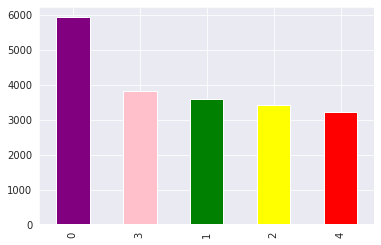

In [ ]:
stats = final_df['labels'].value_counts()
stats.plot(kind='bar', color=['purple', 'pink', 'green', 'yellow', 'red'])
plt.show()

In [ ]:
len(final_df)

19969

In [ ]:
"""final_df=final_df.sample(n=20000)
final_df=final_df.reset_index(drop=True)
final_df"""

'final_df=final_df.sample(n=20000)\nfinal_df=final_df.reset_index(drop=True)\nfinal_df'

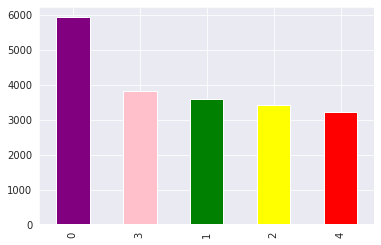

In [ ]:
stats = final_df['labels'].value_counts()
stats.plot(kind='bar', color=['purple', 'pink', 'green', 'yellow', 'red'])
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
df_train,df_val = train_test_split(final_df,test_size=0.15, random_state=42)
df_train,df_test = train_test_split(df_train,test_size=0.10, random_state=42)

df_train.shape,df_val.shape,df_test.shape

((15275, 4), (2996, 4), (1698, 4))

In [ ]:
df_train,df_val,df_test=df_train.reset_index(drop=True),df_val.reset_index(drop=True),df_test.reset_index(drop=True)
df_train

,images,labels,PIL,label
0,"""111938618893743_1028960673858195"".jpg",4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,num_angrys
1,"""5550296508_10155176771491509"".jpg",4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,num_angrys
2,"""86680728811_10153908354478812"".jpg",3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,num_sads
3,"""155869377766434_1502258826460809"".jpg",0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,num_loves
4,"""86680728811_10154956736888812"".jpg",1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,num_wows
...,...,...,...,...
15270,"""131459315949_10153744918700950"".jpg",2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,num_hahas
15271,"""228735667216_10153944922287217"".jpg",0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,num_loves
15272,"""86680728811_10154355014938812"".jpg",3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,num_sads
15273,"""86680728811_10154278128938812"".jpg",2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,num_hahas


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
"""import datasets
data_transforms =  transforms.Compose([
                    transforms.ToPILImage(),
                     transforms.Resize((128,128)),
                  ])
train_dataset=ImageDataset(path,df_train,data_transforms)
val_dataset=ImageDataset(path,df_val,data_transforms)
test_dataset=ImageDataset(path,df_test,data_transforms)
News = datasets.DatasetDict({"train":train_dataset,"test":test_dataset})"""

'import datasets\ndata_transforms =  transforms.Compose([\n                    transforms.ToPILImage(),\n                     transforms.Resize((128,128)),\n                  ])\ntrain_dataset=ImageDataset(path,df_train,data_transforms)\nval_dataset=ImageDataset(path,df_val,data_transforms)\ntest_dataset=ImageDataset(path,df_test,data_transforms)\nNews = datasets.DatasetDict({"train":train_dataset,"test":test_dataset})'

In [ ]:
from datasets.dataset_dict import DatasetDict
from datasets import Dataset
dataset = {'train':Dataset.from_dict({'label':df_train['labels'],'images':df_train['PIL']}),
     'val':Dataset.from_dict({'label':df_val['labels'],'images':df_val['PIL']}),
     'test':Dataset.from_dict({'label':df_test['labels'],'images':df_test['PIL']})
     }

DatasetDict(dataset)

DatasetDict({
    train: Dataset({
        features: ['label', 'images'],
        num_rows: 15275
    })
    val: Dataset({
        features: ['label', 'images'],
        num_rows: 2996
    })
    test: Dataset({
        features: ['label', 'images'],
        num_rows: 1698
    })
})

In [ ]:
dataset

{'test': Dataset({
     features: ['label', 'images'],
     num_rows: 1698
 }), 'train': Dataset({
     features: ['label', 'images'],
     num_rows: 15275
 }), 'val': Dataset({
     features: ['label', 'images'],
     num_rows: 2996
 })}

In [ ]:
example = dataset["train"][10]
example

{'images': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7F13DD265050>,
 'label': 2}

In [ ]:
dataset['train'].features

{'images': Image(decode=True, id=None), 'label': Value(dtype='int64', id=None)}

In [ ]:
features={'num_loves','num_wows','num_hahas','num_sads','num_angrys'}
features

{'num_angrys', 'num_hahas', 'num_loves', 'num_sads', 'num_wows'}

In [ ]:
label2id, id2label = dict(), dict()
for i, label in enumerate(features):
    label2id[label] = i
    id2label[i] = label

id2label[2]

'num_loves'

In [ ]:
model_checkpoint = "facebook/convnext-tiny-224" # pre-trained model from which to fine-tune
batch_size = 32 # batch size for training and evaluation
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
feature_extractor

ConvNextFeatureExtractor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ConvNextFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "size": 224
}

In [ ]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
        [
            RandomResizedCrop(feature_extractor.size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["images"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["images"]]
    return example_batch

In [ ]:
train_ds = dataset['train']
val_ds = dataset['test']

In [ ]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

Parameter 'transform'=<function preprocess_train at 0x7f13dd1f0c20> of the transform datasets.arrow_dataset.Dataset.set_format couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [ ]:
train_ds[0]

{'images': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7F13DD265C10>,
 'label': 4,
 'pixel_values': tensor([[[ 0.8961,  0.8276,  0.7762,  ...,  0.3309, -0.1486, -0.8678],
          [ 0.9303,  0.8276,  0.7591,  ..., -0.1143, -0.5424, -0.8849],
          [ 0.9303,  0.8447,  0.7419,  ..., -0.3369, -0.8849, -1.0904],
          ...,
          [ 0.3138,  1.0673,  0.0056,  ...,  1.5639,  1.5468,  1.5297],
          [-0.2513,  0.8104,  0.7419,  ...,  1.5468,  1.5125,  1.4954],
          [-0.7822,  0.0912,  1.1872,  ...,  1.5297,  1.4954,  1.4612]],
 
         [[-0.3550, -0.3901, -0.4251,  ..., -0.5826, -0.9153, -1.5280],
          [-0.3200, -0.3901, -0.4601,  ..., -0.9853, -1.2654, -1.4755],
          [-0.3200, -0.4076, -0.4776,  ..., -1.1779, -1.5455, -1.5980],
          ...,
          [ 0.3277,  1.0105, -0.1800,  ...,  0.4328,  0.4328,  0.4503],
          [-0.2675,  0.7479,  0.5728,  ...,  0.4153,  0.4328,  0.4678],
          [-0.8102,  0.0126,  1.0280,  ...,  0.4328,

In [ ]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)


Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetned-NewsImageClassification",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=15,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

In [ ]:
args

TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=IntervalStrategy.EPOCH,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
full_determinism=False,
gradient_accumulation_steps=4,
gradient_checkpointing=False,
greater_is_better=True,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=HubStrategy.EVERY_SAVE,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_metrics=False,
jit_mode_eval=False,
label_names=None,
label_smoothing_fac

In [ ]:
from datasets import load_metric

metric = load_metric("accuracy")

In [ ]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [ ]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
!pip install git-lfs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!huggingface-cli lfs-enable-largefiles

usage: huggingface-cli <command> [<args>] lfs-enable-largefiles [-h] path
huggingface-cli <command> [<args>] lfs-enable-largefiles: error: the following arguments are required: path


In [ ]:
#!huggingface-cli login



In [ ]:
#!git config --global credential.helper store


In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

Cloning https://huggingface.co/Sheeza/convnext-tiny-224-finetned-NewsImageClassification into local empty directory.


In [ ]:
train_results = trainer.train()
# rest is optional but nice to have


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 15275
  Num Epochs = 15
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 1785


Epoch,Training Loss,Validation Loss,Accuracy
0,1.544200,1.531728,0.312132
1,1.474000,1.454527,0.381625
2,1.431000,1.427369,0.396349
3,1.418800,1.406914,0.404594
4,1.381700,1.403031,0.402238
5,1.365500,1.400325,0.409305
6,1.311000,1.395117,0.418728
7,1.328300,1.396320,0.422261
8,1.305500,1.399281,0.420495
9,1.249800,1.398880,0.419317


***** Running Evaluation *****
  Num examples = 1698
  Batch size = 32
Saving model checkpoint to convnext-tiny-224-finetned-NewsImageClassification/checkpoint-119
Configuration saved in convnext-tiny-224-finetned-NewsImageClassification/checkpoint-119/config.json
Model weights saved in convnext-tiny-224-finetned-NewsImageClassification/checkpoint-119/pytorch_model.bin
Feature extractor saved in convnext-tiny-224-finetned-NewsImageClassification/checkpoint-119/preprocessor_config.json
Feature extractor saved in convnext-tiny-224-finetned-NewsImageClassification/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 1698
  Batch size = 32
Saving model checkpoint to convnext-tiny-224-finetned-NewsImageClassification/checkpoint-238
Configuration saved in convnext-tiny-224-finetned-NewsImageClassification/checkpoint-238/config.json
Model weights saved in convnext-tiny-224-finetned-NewsImageClassification/checkpoint-238/pytorch_model.bin
Feature extractor saved in convnext